In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr
from scipy.stats import linregress

from xrspatial import aspect, slope

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [35]:
dss = {fp.stem:xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data').expanduser().glob('*.nc')}
for ds in dss.values():
    ds['aspect'] = aspect(ds['lidar-dem'])
    ds['easting'] = np.sin(np.deg2rad(aspect(ds['lidar-dem'])))
    ds['northing'] = np.cos(np.deg2rad(aspect(ds['lidar-dem'])))

lidar-sd
Slope: -0.1240680617172739. p: 6.35638083379357e-05
fcf
Slope: 0.04497243231449199. p: 1.0507390375689126e-18
lidar-dem
Slope: -0.00018498232557125335. p: 8.255235629826667e-06
aspect
Slope: 0.002105358096984392. p: 1.2939391211372324e-06


/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


s1
Slope: -0.002547176188200319. p: 0.00013073127016988837


/tmp/ipykernel_27163/248676616.py:144: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


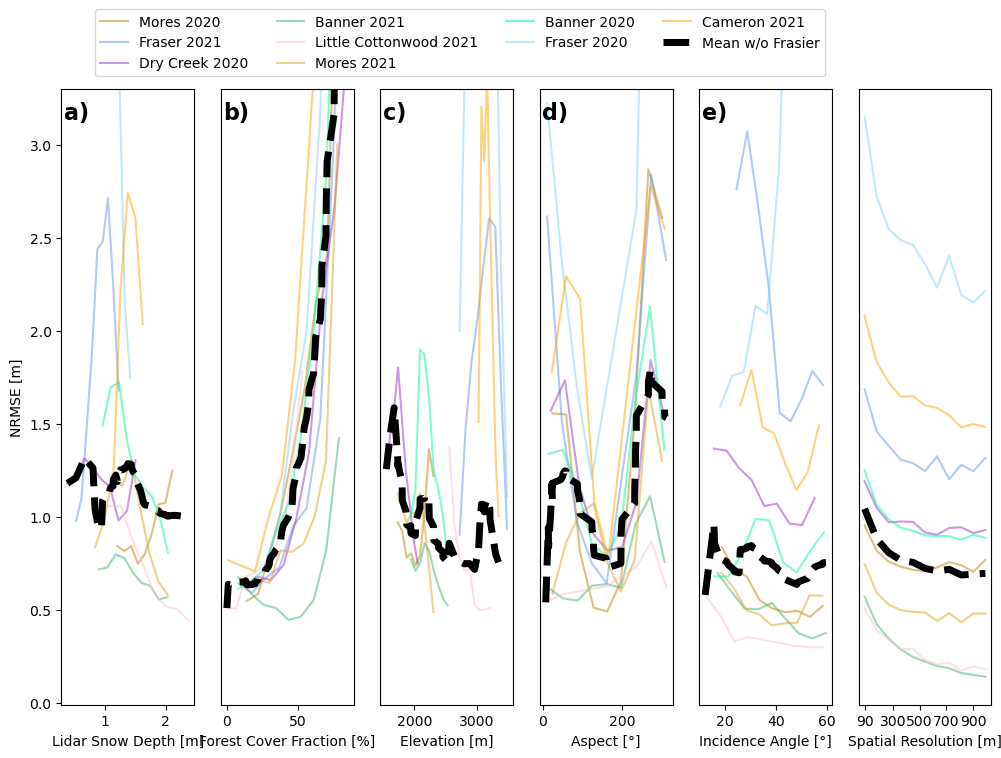

In [37]:
fig, axes = plt.subplots(1, 6, figsize = (12,8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

x_labels = {'lidar-sd': 'Lidar Snow Depth [m]', 'fcf':'Forest Cover Fraction [%]', 'lidar-dem': 'Elevation [m]', 'aspect':'Aspect [°]', 's1':'Incidence Angle [°]'} # 'lidar-dem': 'Elevation [m]', , 'lidar-vh': 'Tree Height [m]'

for (var, label), ax in zip(x_labels.items(), axes.ravel()):

    ss = []
    f_ss = []
    for stem, ds in dss.items():
        # if 'Frasier' in stem.split('-')[0].replace('_', ' ') or 'Cameron' in stem:
            # continue
        # ds = ds.where(ds['wet_snow'] == 0)

        if var == 's1':
            time_ds = ds.sel(band = 'inc')
            time_ds['s1'] = time_ds['s1'].isel(time = slice(len(np.unique(time_ds.relative_orbit)))).std(dim = 'time')
            # time_ds = time_ds.where(time_ds['lidar-dem'] > time_ds['lidar-dem'].quantile(0.5))

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        res = pd.Series(dtype = float)

        for cat, sub in time_ds.sel(band = 'inc').groupby_bins(var, np.linspace(*time_ds.sel(band = 'inc')[var].quantile([0.05, 0.95]).values.ravel(), 10)):

            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))

            if len(x[idx]) < 100:
                continue

            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx])  / np.nanmean(y[idx])

            if var == 's1':
                res.loc[np.rad2deg(cat.left)] = rmse_result / np.nanmean(x)
            elif var == 'lidar-sd':
                res.loc[cat.left] = rmse_result #/ np.nanmean(x)
            elif var == 'fcf':
                res.loc[cat.left * 100] = rmse_result
            else:
                res.loc[cat.left] = rmse_result
                    
        res.sort_index().plot(ax= ax, color = loc_colors[stem], label = stem.split('-')[0].replace('_', ' ').replace('Frasier', 'Fraser'), alpha = 0.5)
        if 'Frasier' not in stem.split('-')[0].replace('_', ' '): # and 'Cameron' not in stem:
            ss.append(res.sort_index())
        else:
            f_ss.append(res.sort_index())
    
    # add mean line
    # vs = [10, 20, 30, 40,50, 60]
    # ss_new = [s.append(pd.Series({v:np.nan for v in vs})) for s in ss]
    if var == 'fcf':
        ss.extend(f_ss)
        df = pd.concat(ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean - Frasier')
    else:
        df = pd.concat(ss, axis = 1).sort_index()
        df_f = pd.concat(f_ss, axis = 1).sort_index()
        df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean w/o Frasier')
        # df_f.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Frasier')

    ax.set_xlabel(label)
    ax.set_ylim(-0.01, 3.3)
    print(var)
    # print((df.interpolate().mean(axis = 1).iloc[-1] - df.interpolate().mean(axis = 1).iloc[0])/ (df.interpolate().mean(axis = 1).index[-1] - df.interpolate().mean(axis = 1).index[0]))
    lm = linregress(x = df.interpolate().mean(axis = 1).index, y = df.interpolate().mean(axis = 1).values)
    print(f'Slope: {lm.slope}. p: {lm.pvalue}')
axes[0].set_ylabel('NRMSE [m]')
# axes[0].set_ylabel('RMSE [m]')
axes[0].legend(loc='upper left',
    bbox_to_anchor=(0.2, 1.14),
    ncol=4,
    # borderaxespad=0.15, 
    # fontsize=8,
    # frameon=False,
)

# add scaling axis
res = pd.DataFrame()

for stem, ds in dss.items():
    if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
    else:
        time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
    site_name = stem.replace('_', ' ').split('-')[0]

    xs = []
    rs = []
    rmses = []
    for look in range(1, 12):
        ds_500 = time_ds.coarsen(x = look, y = look, boundary = 'pad').mean()
        # r, b, mae, rmse_values  = get_stats(ds_500['lidar-sd'], ds_500['snow_depth'])
        x, y = ds_500['lidar-sd'].values.ravel(), ds_500['snow_depth'].values.ravel()
        idx = (~np.isnan(x)) & (~np.isnan(y))

        rmse_result = rmse(x[idx], y[idx])  / np.nanmean(y[idx])
        r = 1

        xs.append(look)
        rs.append(r)
        rmses.append(rmse_result)
        if 'Frasier' not in stem.split('-')[0].replace('_', ' '):
            res.loc[stem, f'r_{look}'] = r
            res.loc[stem, f'rmse_{look}'] = rmse_result
        
    axes[-1].plot(xs, rmses, color = loc_colors[stem], label = site_name, alpha = 0.5)

xs = []
rmses = []
rs = []
for n,v in res.mean().items():
    stat, look = n.split('_')
    if stat == 'r':
        rs.append(v)
        xs.append(int(look))
    elif stat == 'rmse':
        rmses.append(v)

axes[-1].plot(xs, rmses, color = 'black', linewidth = 5, linestyle = 'dashed')
    

ax = axes[-1]
ax.set_xlabel('Spatial Resolution [m]')
ax.set_xticks([1, 300/90, 500/90, 700/90, 900/90])
ax.set_xticklabels(['90','300', '500', '700','900'])

# done adding scalling axis

for ax in axes[1:]:
    ax.set_yticks([])

for ax, letter in zip(axes, ['a','b','c', 'd', 'e']):
    ax.text(0.02, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)


plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/rmse_binned.png')